In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from datagen import generate_image
from model import RPN

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
model_path = 'model/rpn/model'

tf.reset_default_graph()
model = RPN()
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from model/rpn/model


In [4]:
image, gt_cls, gt_boxes = generate_image(train=False)
feed_dict = {
    model.images: image.reshape([1, 224, 224, 1])
}
gt_boxes

array([[ 0.7309417 ,  0.08520179,  0.9103139 ,  0.21076233],
       [ 0.04035874,  0.03587444,  0.11210762,  0.18834081],
       [-0.0044843 , -0.0044843 , -0.00896861, -0.00896861],
       [-0.0044843 , -0.0044843 , -0.00896861, -0.00896861]])

In [5]:
probs = sess.run(model.cls_probs, feed_dict)
probs.shape

(1, 49980, 2)

In [6]:
pred_anchors = sess.run(model.inference, feed_dict)
pred_anchors.shape

(100, 4)

In [19]:
pred_scores = sess.run(model.scores, feed_dict)
pred_scores[:5]

array([0.5121524 , 0.51145947, 0.51134336, 0.5112916 , 0.51123965],
      dtype=float32)

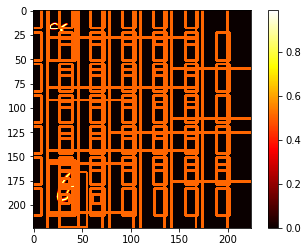

In [26]:
disp = image.copy()
for score, (y1, x1, y2, x2) in zip(pred_scores, pred_anchors):
    color = [float(score)] * 3
    cv2.rectangle(disp, (x1, y1), (x2, y2), color, 2)
plt.imshow(disp, cmap='hot')
plt.colorbar();

In [9]:
%%script false
assert False

In [10]:
anchors, labels = sess.run([model.anchors, model.labels], feed_dict={
    model.images: image.reshape([1, 224, 224, 1]),
    model.gt_boxes: [gt_boxes]
})
anchors.shape, labels.shape

((6000, 4), (6000,))

In [11]:
pos_anchors = anchors[labels == 1]
pos_anchors.shape

(3, 4)

In [12]:
def apply_anchor_deltas(anchors, deltas):
    """
        anchors: [N, (y1, x1, y2, x2)]
        deltas: [N, (dy, dx, log(dh), log(dw)]
    """
    # convert to (y, x, h, w)
    heights = anchors[:, 2] - anchors[:, 0]
    widths = anchors[:, 3] - anchors[:, 1]
    c_y = anchors[:, 0] + 0.5 * heights
    c_x = anchors[:, 1] + 0.5 * widths
    # apply the deltas
    c_y = c_y + deltas[:, 0] * heights
    c_x = c_x + deltas[:, 1] * widths
    heights = heights * np.exp(deltas[:, 2])
    widths = widths * np.exp(deltas[:, 3])
    # convert back to (y1, x1, y2, x2)
    y1 = c_y - 0.5 * heights
    x1 = c_x - 0.5 * widths
    y2 = y1 + heights
    x2 = x1 + widths
    return np.stack([y1, x1, y2, x2], axis=1)

In [13]:
bboxes = pos_anchors
bboxes.shape

(3, 4)

In [14]:
bboxes

array([[161,  25, 207,  47],
       [161,  21, 207,  43],
       [  5,   1,  27,  47]], dtype=int32)

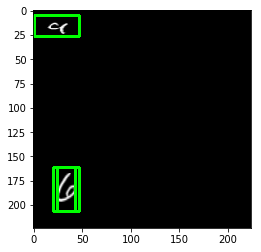

In [15]:
disp = cv2.merge([(image * 255).astype(np.uint8)] * 3)
for y1, x1, y2, x2 in bboxes:
    cv2.rectangle(disp, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(disp);